In [12]:
#libraries
import numpy as np
from skimage import io, color, feature ,transform
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import convolve
from skimage.io import imread
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters import gaussian

C:\Users\cinde\AppData\Local\Temp\ipykernel_8332\466099609.py:7: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


Text(0.5, 1.0, 'Live image')

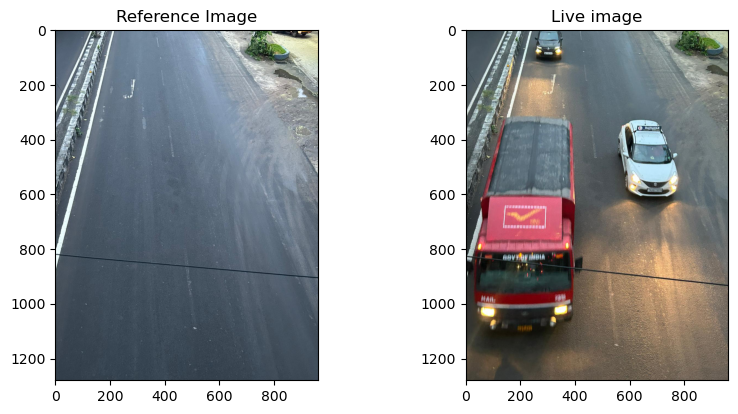

In [13]:
# Load the two images
image1= io.imread(r"D:\CSE\7th sem\mini project\Reference1.jpeg")
image2= io.imread(r"D:\CSE\7th sem\mini project\live11.jpeg")

plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

plt.subplot(2, 3, 1)
plt.imshow(image1, cmap='gray')
plt.title('Reference Image')

# Subplot 2
plt.subplot(2, 3, 2)
plt.imshow(image2, cmap='gray')
plt.title('Live image')

In [14]:
#Resize
min_shape = min(image1.shape, image2.shape)
image1 = transform.resize(image1, min_shape)
image2 = transform.resize(image2, min_shape)

Text(0.5, 1.0, 'Live image')

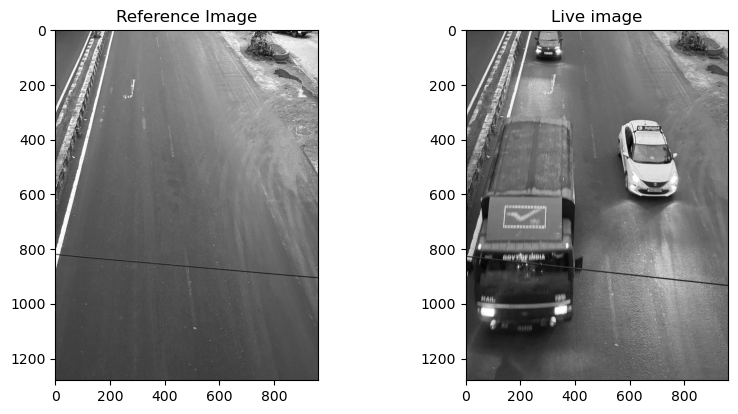

In [15]:
#grayscale conversion
image1 = rgb2gray(image1)
image2 = rgb2gray(image2)

plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

plt.subplot(2, 3, 1)
plt.imshow(image1, cmap='gray')
plt.title('Reference Image')

# Subplot 2
plt.subplot(2, 3, 2)
plt.imshow(image2, cmap='gray')
plt.title('Live image')

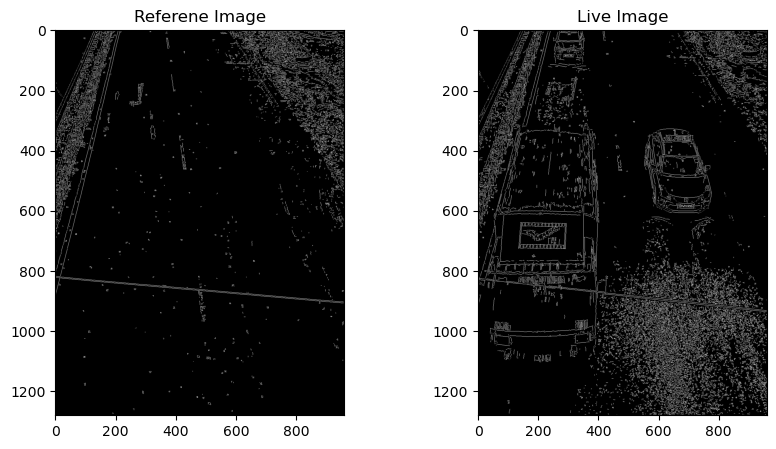

In [16]:
# Perform Canny edge detection on the images

def canny_edge_detection(image, sigma=1.0, high_threshold=0.2, low_threshold=0.1):
    # Convert the image to grayscale
    gray_image = image
    
    # Apply Gaussian smoothing to the image
    smoothed_image = gaussian(gray_image, sigma=sigma)
    
    # Calculate gradients using Sobel operators
    gradient_x = convolve(smoothed_image, np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]))
    gradient_y = convolve(smoothed_image, np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]))
    
    # Calculate gradient magnitude and direction
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x)
    
    # Non-maximum suppression
    suppressed = np.zeros_like(gradient_magnitude)
    angles = np.rad2deg(gradient_direction)
    angles[angles < 0] += 180
    
    for i in range(1, gradient_magnitude.shape[0] - 1):
        for j in range(1, gradient_magnitude.shape[1] - 1):
            angle = angles[i, j]
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                neighbors = (gradient_magnitude[i, j+1], gradient_magnitude[i, j-1])
            elif (22.5 <= angle < 67.5):
                neighbors = (gradient_magnitude[i-1, j+1], gradient_magnitude[i+1, j-1])
            elif (67.5 <= angle < 112.5):
                neighbors = (gradient_magnitude[i-1, j], gradient_magnitude[i+1, j])
            else:
                neighbors = (gradient_magnitude[i-1, j-1], gradient_magnitude[i+1, j+1])
            if gradient_magnitude[i, j] >= max(neighbors):
                suppressed[i, j] = gradient_magnitude[i, j]
    
    # Apply double thresholding to detect strong and weak edges
    strong_edges = suppressed > high_threshold
    weak_edges = (suppressed >= low_threshold) & (suppressed <= high_threshold)
    
    # Edge tracking by hysteresis
    result = np.zeros_like(gradient_magnitude)
    result[strong_edges] = 1
    for i in range(1, gradient_magnitude.shape[0] - 1):
        for j in range(1, gradient_magnitude.shape[1] - 1):
            if weak_edges[i, j]:
                neighbors = result[i-1:i+2, j-1:j+2]
                if np.max(neighbors) == 1:
                    result[i, j] = 1
    
    return result

edges1 = canny_edge_detection(image1)
edges2 = canny_edge_detection(image2)



plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)  # Subplot 1
plt.imshow(edges1, cmap='gray')
plt.title('Referene Image')

plt.subplot(1, 2, 2)  # Subplot 2
plt.imshow(edges2, cmap='gray')
plt.title('Live Image')

plt.show()

In [17]:

# Calculate the structural similarity index between the edge images
def calculate_ssim(image1, image2, K1=0.04, K2=0.07, L=3.9):
    """
    Calculate SSIM for two images (single scale).
    
    Args:
    image1, image2: Input images (grayscale, same shape).
    K1, K2: Constants to avoid division by zero.
    L: Dynamic range of pixel values (usually 255 for 8-bit images).

    Returns:
    SSIM score (between -1 and 1).
    """

    # Calculate the mean of the two images
    mu1 = np.mean(image1)
    mu2 = np.mean(image2)

    # Calculate the variance of the two images
    sigma1 = np.var(image1)
    sigma2 = np.var(image2)

    # Calculate the covariance of the two images
    sigma12 = np.cov(image1, image2)[0, 1]

    # Constants for SSIM calculation
    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2

    # SSIM formula
    numerator = (2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)
    denominator = (mu1 ** 2 + mu2 ** 2 + C1) * (sigma1 + sigma2 + C2)

    ssim = numerator / denominator

    return ssim


# Calculate SSIM
ssim = calculate_ssim(edges1,edges2)
s=ssim*100
print(f"SSIM Score: {s:.4f}")

SSIM Score: 41.9273


In [18]:
if 95 < s <= 100:
    print("time: 10 seconds")
elif 80 < s <= 95:
    degT = (s - 80) / 15
    time = (degT * 30) + 10
    print(f"time: {time:.4f} seconds")
elif 61< s <= 80:
    print("time: 40 seconds")

elif 30 < s <= 60:
    degT = (s - 30) / 30
    time = (degT * 50) + 40
    print(f"time: {time:.4f} seconds")
elif 11 < s <= 30:
    print("time: 90 seconds")
    

time: 59.8788 seconds
